# Analytical Bistable Half-Beam Force-Displacement Model

Energy minimization approach based on Qiu, Lang & Slocum (JMEMS 2004),
adapted for the CCS **half-beam** geometry used in the bistable spring pair.

The half-beam spans from anchor (x=0, y=0) to shuttle (x=L, y=h) with
both endpoints approaching horizontally (dy/dx=0).  Mode shapes:
$$\psi_n(x) = \frac{1}{2}\left[1 - \cos\left(\frac{n\pi x}{L}\right)\right], \quad n = 1, 2, 3, 4, 5$$

- Odd $n$: $\psi_n(L) = 1$ (contribute to shuttle displacement)
- Even $n$: $\psi_n(L) = 0$ (internal shape redistribution)

Constraint: $a_1 + a_3 + a_5 = \delta$ (total shuttle y-position).
Force $F = -dU_{\min}/d\delta$.

In [1]:
import sys
import os
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS,
    get_beam_centerline, get_beam_width_profile,
    get_moment_of_inertia_profile,
)

# Half-beam parameters
L = DEFAULT_BEAM_PARAMS["half_span"]       # 20 µm
h = DEFAULT_BEAM_PARAMS["initial_offset"]  # 1.2 µm
t = POLY_SI["t"]                           # 0.5 µm
E = POLY_SI["E"]                           # 160,000 MPa
nu = POLY_SI["nu"]                         # 0.22

Q = h / t
print(f"Bistability ratio Q = h/t = {Q:.2f} (need > 2.31 for bistability)")
print(f"Half-beam: L={L} µm, h={h} µm, t={t} µm, E={E/1e3:.0f} GPa")

Bistability ratio Q = h/t = 2.40 (need > 2.31 for bistability)
Half-beam: L=20.0 µm, h=1.2 µm, t=0.5 µm, E=160 GPa


## 1. Half-Beam Geometry Visualization

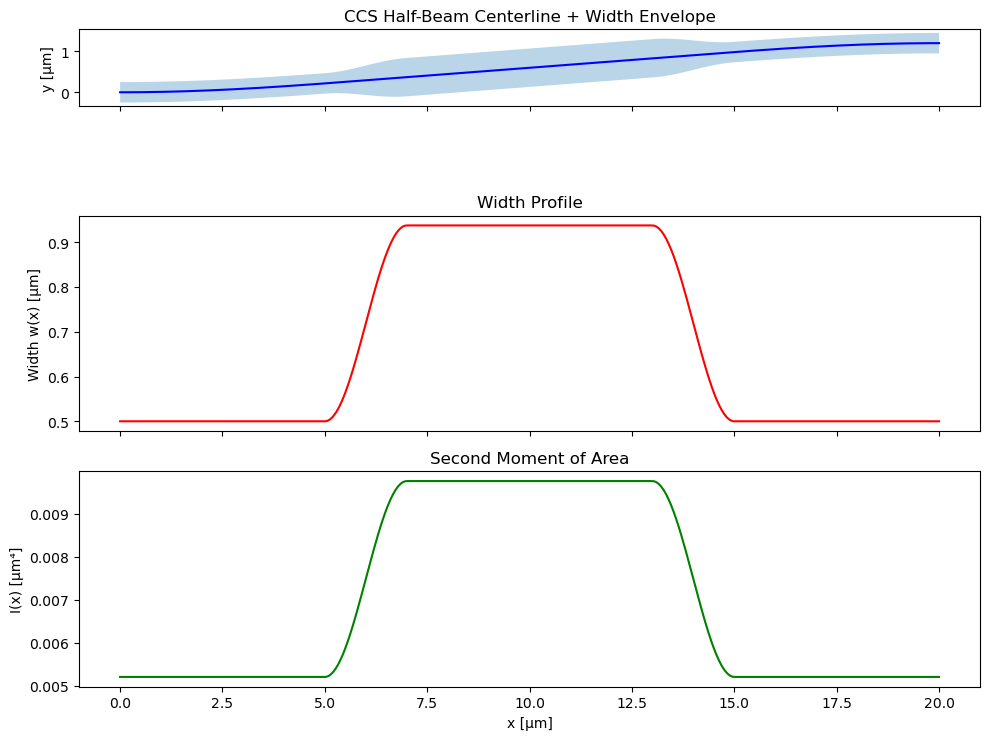

In [2]:
x_cl, y_cl = get_beam_centerline()
w_prof = get_beam_width_profile(x_cl)
I_prof = get_moment_of_inertia_profile(x_cl)

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(x_cl, y_cl, 'b-', linewidth=1.5)
axes[0].fill_between(x_cl, y_cl - w_prof/2, y_cl + w_prof/2, alpha=0.3)
axes[0].set_ylabel('y [µm]')
axes[0].set_title('CCS Half-Beam Centerline + Width Envelope')
axes[0].set_aspect('equal')

axes[1].plot(x_cl, w_prof, 'r-', linewidth=1.5)
axes[1].set_ylabel('Width w(x) [µm]')
axes[1].set_title('Width Profile')

axes[2].plot(x_cl, I_prof, 'g-', linewidth=1.5)
axes[2].set_ylabel('I(x) [µm⁴]')
axes[2].set_xlabel('x [µm]')
axes[2].set_title('Second Moment of Area')

fig.tight_layout()
fig.savefig('plots/analytical_beam_geometry.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Mode Shape Functions

Half-beam modes with zero slope at both ends (anchor and shuttle):
$$\psi_n(x) = \frac{1}{2}\left[1 - \cos\left(\frac{n\pi x}{L}\right)\right], \quad n = 1, 2, 3, 4, 5$$

Properties:
- $\psi_n(0) = 0$, $\psi_n'(0) = 0$ (clamped anchor)
- $\psi_n'(L) = 0$ (horizontal shuttle attachment)
- Odd $n$: $\psi_n(L) = 1$; Even $n$: $\psi_n(L) = 0$

In [3]:
# Half-beam mode shapes: psi_n(x) = 0.5[1 - cos(n*pi*x/L)]
# Note: these use n*pi*x/L (not 2n as in the full-beam formulation)
modes = [1, 2, 3, 4, 5]
odd_modes = [1, 3, 5]

def psi(n, x, L):
    """Mode shape function."""
    return 0.5 * (1.0 - np.cos(n * np.pi * x / L))

def psi_xx(n, x, L):
    """Second derivative of mode shape (curvature)."""
    return 0.5 * (n * np.pi / L)**2 * np.cos(n * np.pi * x / L)

def psi_x(n, x, L):
    """First derivative of mode shape (slope)."""
    return 0.5 * (n * np.pi / L) * np.sin(n * np.pi * x / L)

# Verify modes
x_fine = np.linspace(0, L, 1000)
for n in modes:
    print(f"psi_{n}(0)={psi(n, 0, L):.3f}, psi_{n}(L)={psi(n, L, L):.3f}, "
          f"psi_{n}'(0)={psi_x(n, 0, L):.6f}, psi_{n}'(L)={psi_x(n, L, L):.6f}")

psi_1(0)=0.000, psi_1(L)=1.000, psi_1'(0)=0.000000, psi_1'(L)=0.000000
psi_2(0)=0.000, psi_2(L)=0.000, psi_2'(0)=0.000000, psi_2'(L)=-0.000000
psi_3(0)=0.000, psi_3(L)=1.000, psi_3'(0)=0.000000, psi_3'(L)=0.000000
psi_4(0)=0.000, psi_4(L)=0.000, psi_4'(0)=0.000000, psi_4'(L)=-0.000000
psi_5(0)=0.000, psi_5(L)=1.000, psi_5'(0)=0.000000, psi_5'(L)=0.000000


## 3. Uniform Beam (Reference)

For a uniform half-beam (constant $I$), the corrected energy formulas are:
- Bending: $U_b = \frac{E I \pi^4}{16 L^3} \sum n^4 a_n^2$
- Axial shortening: $S = \frac{\pi^2}{16 L} \sum n^2 a_n^2$, initial $S_0 = \frac{\pi^2 h^2}{16 L}$
- Axial energy: $U_a = \frac{E A}{2 L} (S - S_0)^2$

Note: the half-beam modes have factors of $n\pi/L$ (not $2n\pi/L$), giving
different prefactors than the full-beam Qiu formulation.

In [4]:
# Uniform beam properties (use flex_width as representative)
w_uniform = DEFAULT_BEAM_PARAMS["flex_width"]  # 0.5 µm
I_uniform = w_uniform * t**3 / 12.0
A_uniform = w_uniform * t

print(f"Uniform beam: w={w_uniform} µm, I={I_uniform:.6f} µm⁴, A={A_uniform:.4f} µm²")


def energy_uniform(a_coeffs, delta, E, I, A, L, h):
    """Total energy for uniform half-beam given mode amplitudes.

    a_coeffs: [a1, a2, a3, a4, a5] mode amplitudes
    Constraint: a1 + a3 + a5 = delta (shuttle y-position)
    """
    # Bending: U_b = E*I*pi^4/(16*L^3) * sum n^4*a_n^2
    U_bend = 0.0
    for n, a in zip(modes, a_coeffs):
        U_bend += n**4 * a**2
    U_bend *= E * I * np.pi**4 / (16.0 * L**3)

    # Axial shortening: S = pi^2/(16*L) * sum n^2*a_n^2
    S = 0.0
    for n, a in zip(modes, a_coeffs):
        S += n**2 * a**2
    S *= np.pi**2 / (16.0 * L)

    S0 = np.pi**2 * h**2 / (16.0 * L)

    # Axial energy
    U_axial = 0.5 * E * A / L * (S - S0)**2

    return U_bend + U_axial


def minimize_energy_uniform(delta, E, I, A, L, h):
    """Minimize over free modes (a2,a3,a4,a5) with a1+a3+a5=delta."""
    def objective(free):
        a2, a3, a4, a5 = free
        a1 = delta - a3 - a5
        return energy_uniform([a1, a2, a3, a4, a5], delta, E, I, A, L, h)

    res = minimize(objective, [0.0, 0.0, 0.0, 0.0], method='Nelder-Mead',
                   options={'xatol': 1e-12, 'fatol': 1e-15, 'maxiter': 10000})
    a2, a3, a4, a5 = res.x
    a1 = delta - a3 - a5
    return res.fun, [a1, a2, a3, a4, a5]


# Sweep shuttle y-position from h (initial) to -h (snapped)
n_steps = 300
delta_range = np.linspace(h, -h, n_steps)
U_min_uniform = np.zeros(n_steps)
amps_uniform = np.zeros((n_steps, 5))

for i, d in enumerate(delta_range):
    U_min_uniform[i], amps_uniform[i] = minimize_energy_uniform(
        d, E, I_uniform, A_uniform, L, h
    )

# Force = -dU/d(delta); positive F resists downward shuttle motion
F_uniform = -np.gradient(U_min_uniform, delta_range)

# Convert to displacement-from-initial for plotting
disp = h - delta_range  # 0 to 2h

F_push_uniform = F_uniform.max()
F_pop_uniform = F_uniform.min()
ratio_uniform = abs(F_pop_uniform / F_push_uniform)
print(f"Uniform half-beam: F_push = {F_push_uniform:.4f} µN, F_pop = {F_pop_uniform:.4f} µN")
print(f"|F_pop/F_push| = {ratio_uniform:.3f}")

Uniform beam: w=0.5 µm, I=0.005208 µm⁴, A=0.2500 µm²
Uniform half-beam: F_push = 1.6909 µN, F_pop = -1.6909 µN
|F_pop/F_push| = 1.000


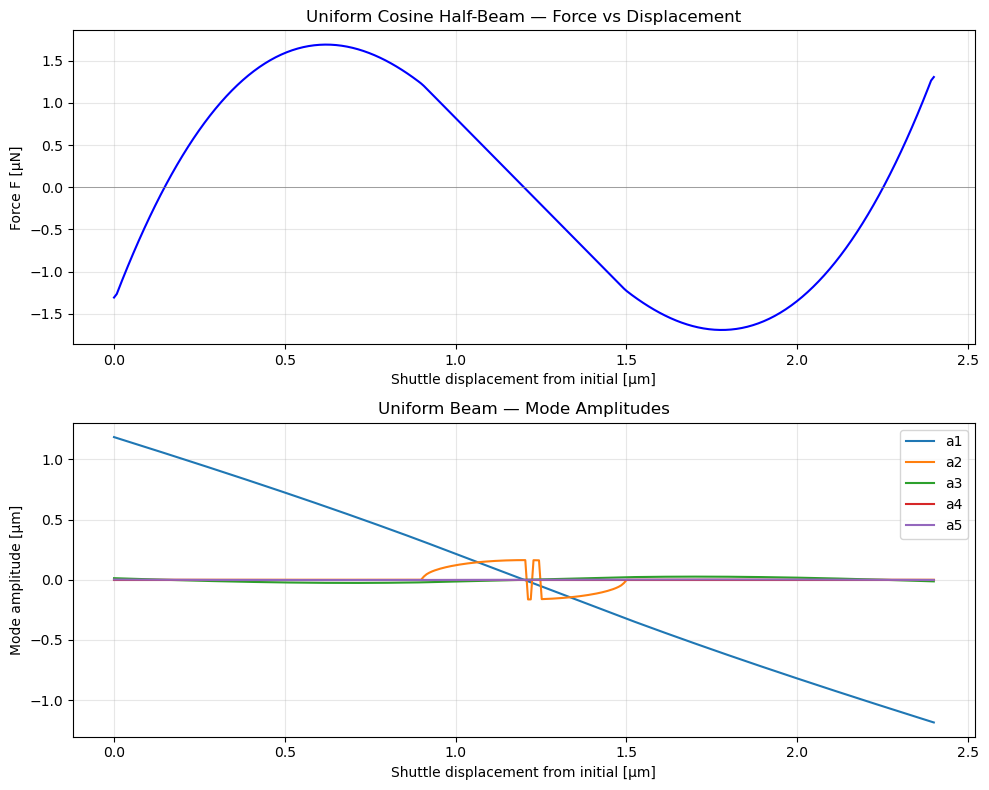

Uniform: F_push = 1.6909 µN, F_pop = -1.6909 µN
|F_pop/F_push| = 1.000


In [5]:
# Plot uniform beam results
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(disp, F_uniform, 'b-', linewidth=1.5)
axes[0].axhline(0, color='gray', linewidth=0.5)
axes[0].set_ylabel('Force F [µN]')
axes[0].set_xlabel('Shuttle displacement from initial [µm]')
axes[0].set_title('Uniform Cosine Half-Beam — Force vs Displacement')
axes[0].grid(True, alpha=0.3)

for j, n in enumerate(modes):
    axes[1].plot(disp, amps_uniform[:, j], label=f'a{n}')
axes[1].set_ylabel('Mode amplitude [µm]')
axes[1].set_xlabel('Shuttle displacement from initial [µm]')
axes[1].set_title('Uniform Beam — Mode Amplitudes')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

print(f"Uniform: F_push = {F_push_uniform:.4f} µN, F_pop = {F_pop_uniform:.4f} µN")
print(f"|F_pop/F_push| = {ratio_uniform:.3f}")

## 4. CCS Half-Beam (Actual Design)

For the CCS half-beam with variable width $w(x)$:
$$\beta_{mn} = E \int_0^L I(x)\, \psi_m''(x)\, \psi_n''(x)\, dx$$

Effective average cross-section area:
$$\bar{A} = \frac{t}{L} \int_0^L w(x)\, dx$$

In [6]:
# CCS-specific bending coefficients via numerical integration
x_int = np.linspace(0, L, 2000)
I_ccs = get_moment_of_inertia_profile(x_int)
w_ccs = get_beam_width_profile(x_int)
A_bar = t * trapezoid(w_ccs, x_int) / L

print(f"Effective avg cross-section area A_bar = {A_bar:.4f} µm²")

# Bending stiffness matrix (includes cross-coupling for variable-I)
beta_cross = {}
for m in modes:
    for n in modes:
        integrand = I_ccs * psi_xx(m, x_int, L) * psi_xx(n, x_int, L)
        beta_cross[(m, n)] = E * trapezoid(integrand, x_int)

print("\nBending stiffness matrix β_mn:")
header = "       " + "  ".join(f"{'n='+str(n):>10s}" for n in modes)
print(header)
for m in modes:
    row = "  ".join(f"{beta_cross[(m,n)]:10.4f}" for n in modes)
    print(f"  m={m}: {row}")

Effective avg cross-section area A_bar = 0.3375 µm²

Bending stiffness matrix β_mn:
              n=1         n=2         n=3         n=4         n=5
  m=1:     1.3794      0.0000     -2.0957      0.0000      4.0890
  m=2:     0.0000     28.9962      0.0000    -17.2336     -0.0000
  m=3:    -2.0957      0.0000    143.8427      0.0000    -91.1114
  m=4:     0.0000    -17.2336      0.0000    419.8838      0.0000
  m=5:     4.0890     -0.0000    -91.1114      0.0000   1070.1682


In [7]:
def energy_ccs(a_coeffs, delta, beta, A_bar, E, L, h):
    """Total energy for CCS half-beam with variable-width bending matrix."""
    # Bending: U = 0.5 * sum_m sum_n a_m * beta_mn * a_n
    U_bend = 0.0
    for i, m in enumerate(modes):
        for j, n in enumerate(modes):
            U_bend += a_coeffs[i] * beta[(m, n)] * a_coeffs[j]
    U_bend *= 0.5

    # Axial shortening: S = pi^2/(16*L) * sum n^2*a_n^2
    S = 0.0
    for n_mode, a in zip(modes, a_coeffs):
        S += n_mode**2 * a**2
    S *= np.pi**2 / (16.0 * L)

    S0 = np.pi**2 * h**2 / (16.0 * L)

    U_axial = 0.5 * E * A_bar / L * (S - S0)**2
    return U_bend + U_axial


def minimize_energy_ccs(delta, beta, A_bar, E, L, h):
    """Minimize over free modes with a1+a3+a5=delta."""
    def objective(free):
        a2, a3, a4, a5 = free
        a1 = delta - a3 - a5
        return energy_ccs([a1, a2, a3, a4, a5], delta, beta, A_bar, E, L, h)

    res = minimize(objective, [0.0, 0.0, 0.0, 0.0], method='Nelder-Mead',
                   options={'xatol': 1e-12, 'fatol': 1e-15, 'maxiter': 10000})
    a2, a3, a4, a5 = res.x
    a1 = delta - a3 - a5
    return res.fun, [a1, a2, a3, a4, a5]


# Sweep
U_min_ccs = np.zeros(n_steps)
amps_ccs = np.zeros((n_steps, 5))

for i, d in enumerate(delta_range):
    U_min_ccs[i], amps_ccs[i] = minimize_energy_ccs(
        d, beta_cross, A_bar, E, L, h
    )

F_ccs = -np.gradient(U_min_ccs, delta_range)

F_push_ccs = F_ccs.max()
F_pop_ccs = F_ccs.min()
ratio_ccs = abs(F_pop_ccs / F_push_ccs)
print(f"CCS half-beam: F_push = {F_push_ccs:.4f} µN, F_pop = {F_pop_ccs:.4f} µN")
print(f"|F_pop/F_push| = {ratio_ccs:.3f}")
print(f"\nNote: For Q={Q:.2f} (close to bistability threshold of 2.31),")
print(f"higher modes do not participate => symmetric force curve (ratio ~ 1.0).")
print(f"This is correct physics — see Qiu (2004) Sec. III-B.")

CCS half-beam: F_push = 2.4814 µN, F_pop = -2.4814 µN
|F_pop/F_push| = 1.000

Note: For Q=2.40 (close to bistability threshold of 2.31),
higher modes do not participate => symmetric force curve (ratio ~ 1.0).
This is correct physics — see Qiu (2004) Sec. III-B.


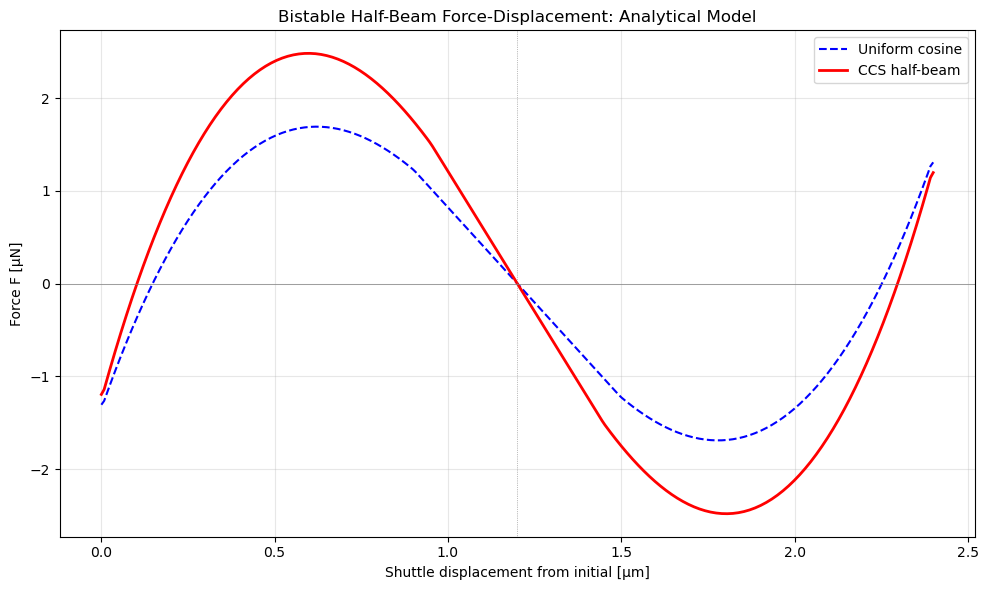

In [8]:
# Force-displacement comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(disp, F_uniform, 'b--', linewidth=1.5, label='Uniform cosine')
ax.plot(disp, F_ccs, 'r-', linewidth=2, label='CCS half-beam')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(h, color='gray', linewidth=0.5, linestyle=':')

ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('Bistable Half-Beam Force-Displacement: Analytical Model')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/analytical_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Energy Landscape

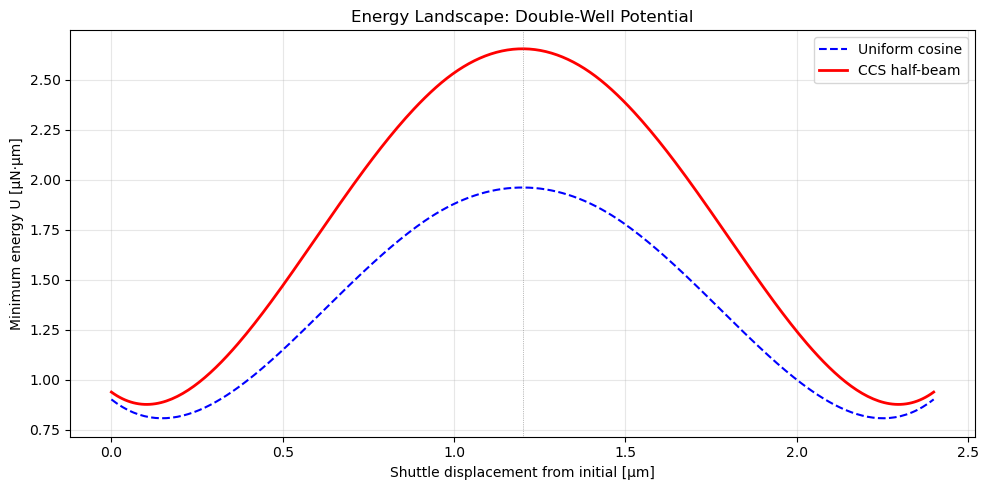

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(disp, U_min_uniform, 'b--', linewidth=1.5, label='Uniform cosine')
ax.plot(disp, U_min_ccs, 'r-', linewidth=2, label='CCS half-beam')
ax.axvline(h, color='gray', linewidth=0.5, linestyle=':')

ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Minimum energy U [µN·µm]')
ax.set_title('Energy Landscape: Double-Well Potential')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/analytical_energy_landscape.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Mode Amplitudes

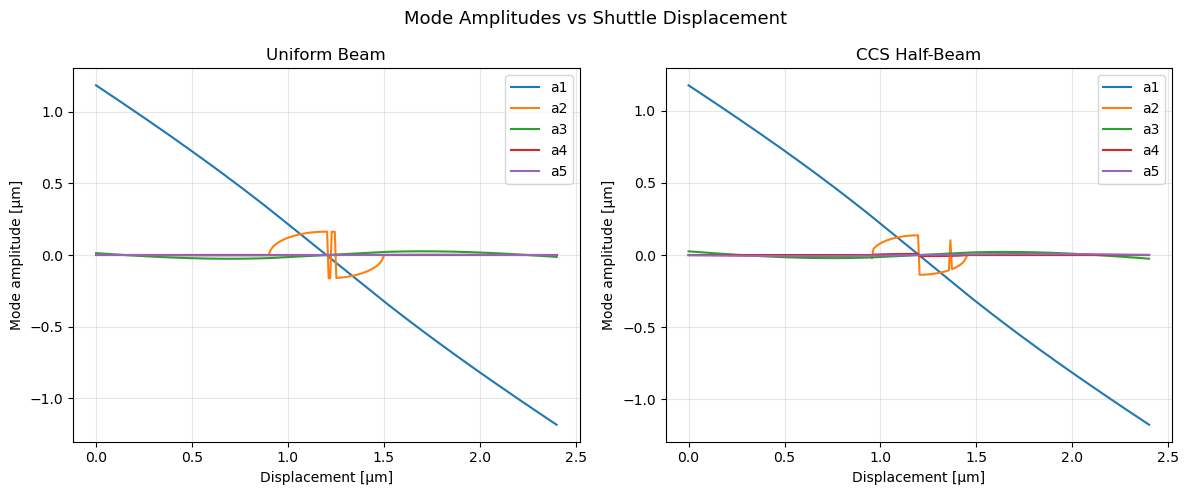

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for j, n in enumerate(modes):
    axes[0].plot(disp, amps_uniform[:, j], label=f'a{n}')
axes[0].set_xlabel('Displacement [µm]')
axes[0].set_ylabel('Mode amplitude [µm]')
axes[0].set_title('Uniform Beam')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for j, n in enumerate(modes):
    axes[1].plot(disp, amps_ccs[:, j], label=f'a{n}')
axes[1].set_xlabel('Displacement [µm]')
axes[1].set_ylabel('Mode amplitude [µm]')
axes[1].set_title('CCS Half-Beam')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fig.suptitle('Mode Amplitudes vs Shuttle Displacement', fontsize=13)
fig.tight_layout()
fig.savefig('plots/analytical_mode_amplitudes.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Deformed Shapes at Key Displacements

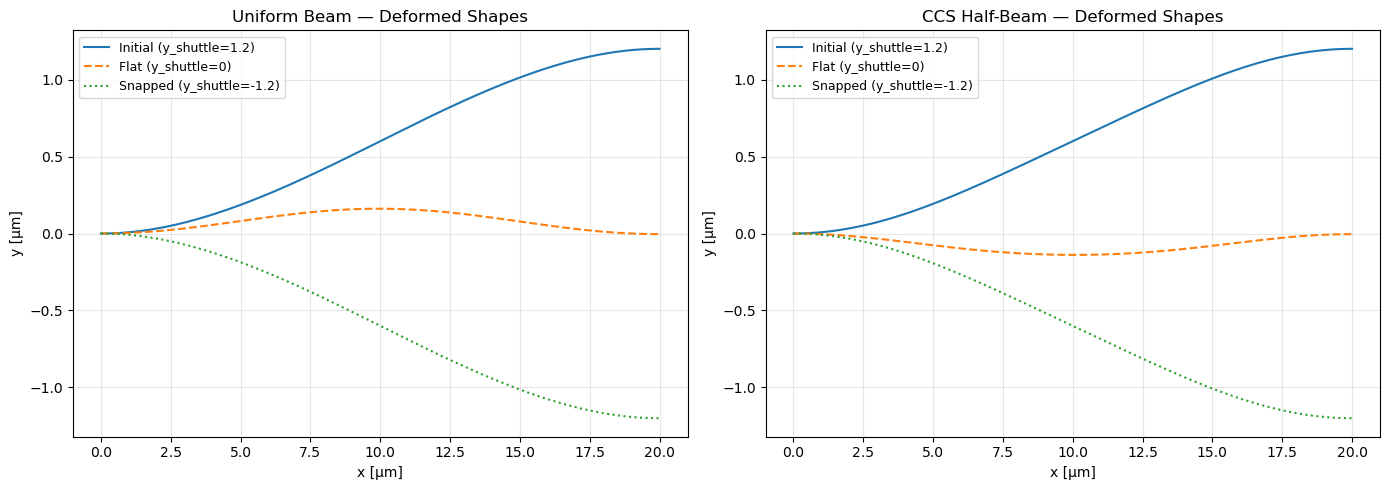

In [11]:
def beam_shape(x, a_coeffs, L):
    """Compute beam deflection w(x) from mode amplitudes."""
    w = np.zeros_like(x)
    for n, a in zip(modes, a_coeffs):
        w += a * psi(n, x, L)
    return w

x_plot = np.linspace(0, L, 500)

key_indices = {
    f'Initial (y_shuttle={h:.1f})': 0,
    f'Flat (y_shuttle=0)': n_steps // 2,
    f'Snapped (y_shuttle={-h:.1f})': -1,
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for (label, idx), ls in zip(key_indices.items(), ['-', '--', ':']):
    y_uni = beam_shape(x_plot, amps_uniform[idx], L)
    y_ccs = beam_shape(x_plot, amps_ccs[idx], L)
    axes[0].plot(x_plot, y_uni, ls, linewidth=1.5, label=label)
    axes[1].plot(x_plot, y_ccs, ls, linewidth=1.5, label=label)

for ax, title in zip(axes, ['Uniform Beam', 'CCS Half-Beam']):
    ax.set_xlabel('x [µm]')
    ax.set_ylabel('y [µm]')
    ax.set_title(f'{title} — Deformed Shapes')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/analytical_deformed_shapes.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results

In [12]:
import csv

# Save force-displacement data (indexed by displacement from initial)
np.savetxt('results/analytical_force_displacement.csv',
           np.column_stack([disp, F_uniform, F_ccs]),
           delimiter=',',
           header='disp_um,F_uniform_uN,F_ccs_uN',
           comments='')

# Save critical values
with open('results/analytical_critical_values.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['method', 'F_push_uN', 'F_pop_uN', 'push_pop_ratio',
                     'total_travel_um'])
    writer.writerow(['uniform_cosine', f'{F_push_uniform:.6f}',
                     f'{F_pop_uniform:.6f}', f'{ratio_uniform:.4f}',
                     f'{2*h:.4f}'])
    writer.writerow(['ccs_half_beam', f'{F_push_ccs:.6f}',
                     f'{F_pop_ccs:.6f}', f'{ratio_ccs:.4f}',
                     f'{2*h:.4f}'])

print("Saved: results/analytical_force_displacement.csv")
print("Saved: results/analytical_critical_values.csv")
print(f"\nSummary (single half-beam; spring pair = 4x):")
print(f"{'':20s} {'F_push':>10s} {'F_pop':>10s} {'Ratio':>8s}")
print(f"{'Uniform':20s} {F_push_uniform:10.4f} {F_pop_uniform:10.4f} {ratio_uniform:8.3f}")
print(f"{'CCS half-beam':20s} {F_push_ccs:10.4f} {F_pop_ccs:10.4f} {ratio_ccs:8.3f}")

Saved: results/analytical_force_displacement.csv
Saved: results/analytical_critical_values.csv

Summary (single half-beam; spring pair = 4x):
                         F_push      F_pop    Ratio
Uniform                  1.6909    -1.6909    1.000
CCS half-beam            2.4814    -2.4814    1.000
